# Half-life period calculation using Machine Learning #

This jupyter notebook resembles my attempts to create a model that predicts a half-life decay using nucleus's characteristics.

This is mainly for *educational purposes*, and I just experiment here with data, trying to create a good model using my knowledge acquired from different courses.

Right now only amounts of protons and neutrons used as a features, but in future I'll try to find different dataset with more important information, for example - energy of decay. 

In [446]:
# Importing basic libraries for data cleaning and plots
import pandas as pd
import matplotlib as plt
import numpy as np

# The following is used for stylized plots:
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

The following is data preparation step, which includes splitting dataset into training and test set.

In [447]:
# Add data to dataframe, select only needed columns and delete NaNs
df = pd.read_csv("decaydata.csv")
df = df.drop(df[df.half_life_sec==' '].index)
df = df[['n','z','half_life_sec']]
df.dropna()

# Split train and test set
df_train = df.sample(frac=0.96)
df_test = df.drop(df_train.index)

# Split features and target
X_train = df_train.drop('half_life_sec', axis=1).to_numpy()
X_test = df_test.drop('half_life_sec', axis=1).to_numpy()
# Take periods to log10 scale
y_train = np.log10(df_train['half_life_sec'].astype(float).to_numpy())
y_test = np.log10(df_test['half_life_sec'].astype(float).to_numpy())

For aesthetic purposes I just wanted to draw all the data on one graph. It just looks nice. :)

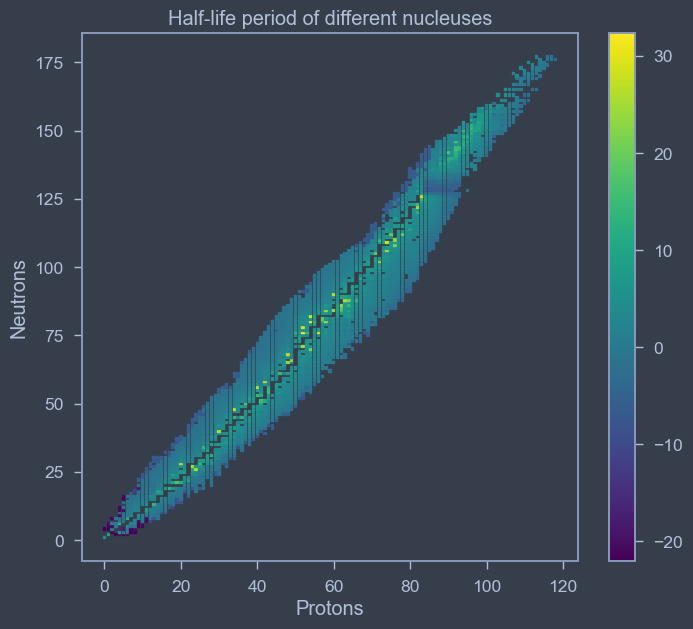

In [448]:
import matplotlib.pyplot as plt
xmpl = df[['n', 'z']].to_numpy().transpose()
y1 = df['half_life_sec'].astype(float).to_numpy()
plt.scatter(xmpl[1], xmpl[0], c = np.log10(y1), s = 6, marker='s')
cbar = plt.colorbar()
plt.ylabel("Neutrons")
plt.xlabel("Protons")
plt.title("Half-life period of different nucleuses")
plt.show()

My first attempt was using random forest regression model. It showed not that bad results, but it always got overfitted for some reason - when the accuracy on train set was like 0.95, the accuracy on test set was like 0.6. I tried different parameters, but it showed same results. 

In [449]:
# Random forest
from sklearn.ensemble import RandomForestRegressor # Random forest algorithm
rf = RandomForestRegressor(n_estimators=10, n_jobs=-1)
rf.fit(X_train, y_train) # Create the model
print("Accuracy of random forest: ", rf.score(X_test, y_test))
print("accuracy on train set: ", rf.score(X_train, y_train))
print(rf.predict([X_test[6]]), y_test[6]) # Random example

Accuracy of random forest:  0.5644286586153635
accuracy on train set:  0.92129447021257
[-2.10381968] -1.9030899869919435


The next attempt was using the multilayer perceptron neural network. The results still had high inacurracy. Notice, that I use log scale, and all the errors should be raised to the 10th power. As a result, error is really big, but anyways I made some progress and the model performed not that bad.

The strange thing is, the model was always underfitted - accuracy on train set was like 0.5 for really big neural networks. I don't know the reason for it yet, but I'll figure it out some day. Right now I think that the dataset just should have more features, because numbers of neutrons and protons don't give much information.

In [457]:
# Neural network MLP
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(max_iter=80000, activation='relu',
                   hidden_layer_sizes=(512, 512, 512))
# The default number of iterations is 200, that's to small. 
mlp.fit(X_train, y_train) 
print("Accuracy: ", mlp.score(X_test, y_test))
print("accuracy on train set:  ", mlp.score(X_train, y_train))

Accuracy:  0.3779140516512024
accuracy on train set:   0.389547885011467


To visualize the model's predictions, I've used matplotlib. On the graph it can be easily seen that the data is actually underfitted.

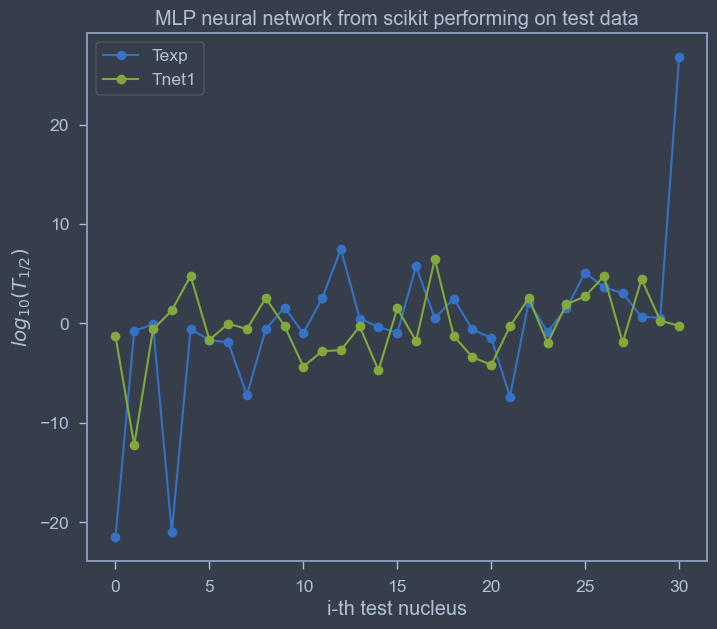

In [458]:
plt.clf()
plt.plot(range(0, 31), y_test[:31], 'o-', label='Texp')
plt.plot(range(0, 31), predicted[:31], 'o-', label='Tnet1')
plt.legend()
plt.ylabel("$log_{10}(T_{1/2})$")
plt.xlabel("i-th test nucleus")
plt.title("MLP neural network from scikit performing on test data")
plt.show()

The following is my attempt of using tensorflow for the same purposes. 

In [452]:
from tensorflow import keras
from tensorflow.keras import layers

# The neural network's model - Sequential is just usual, classic type of neural network.
# In future, different models can be used.
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[2]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

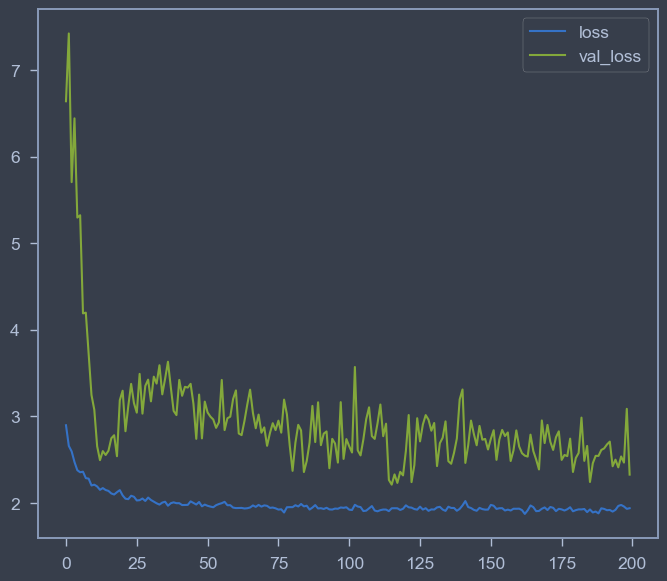

In [453]:
# Add a loss function, which uses mean absolute error and optimizer Adam
model.compile(
    optimizer='adam',
    loss='mae',
)

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=200,
    verbose=0
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

4/4 [==============================] - 0s 7ms/step


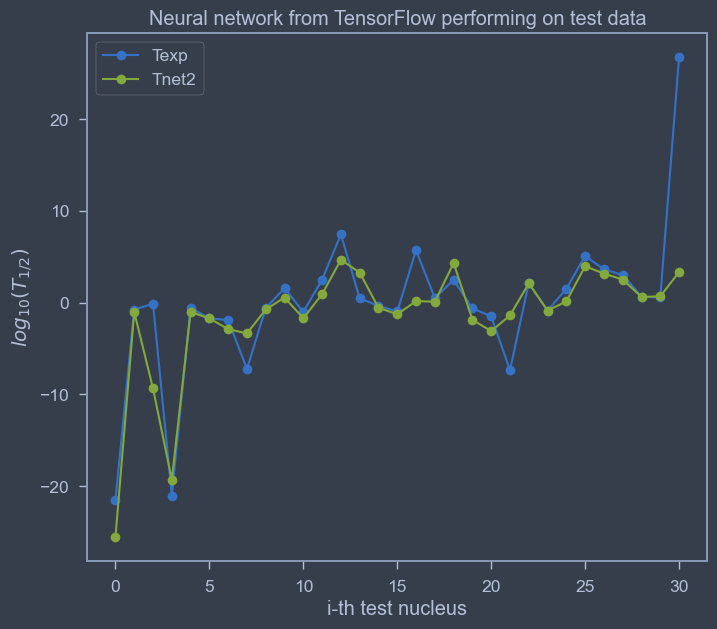

In [454]:
# Make the same visualisation as for the previous neural network
plt.clf()
plt.plot(range(0, 31), y_test[:31], 'o-', label='Texp')
plt.plot(range(0, 31), model.predict(X_test)[:31], 'o-', label='Tnet2')
plt.legend()
plt.ylabel("$log_{10}(T_{1/2})$")
plt.xlabel("i-th test nucleus")
plt.title("Neural network from TensorFlow performing on test data")
plt.show()

Thanks for your attention!
I'll add new thing in this notebook as I progress in machine learning.